# Baseline for English version

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

DATA_DIR = '/Users/admin/edu/NLP/practical_NLP_course/data/'
BLOGS_PREP_EN_FILE = 'blog_authors_preped.csv.gzip'

Now, we can split df to train and test

In [2]:
data = pd.read_csv(DATA_DIR+BLOGS_PREP_EN_FILE, compression='gzip')

In [4]:
all_classes = data['age+sex'].drop_duplicates().tolist()

In [3]:

# X_train, X_test, y_train, y_test = train_test_split(data[['text', 'word_count', 'char_length']],
#                                                     data['age+sex'],
#                                                     test_size=0.2,
#                                                     random_state=249)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# bow_transformer = CountVectorizer().fit(X_train.text)
# how many unique words in the comments
# len(bow_transformer.vocabulary_)

In [5]:
# feature_mapping = bow_transformer.get_feature_names()

lets clean a text before apply the model: delete links, convert all numbers to 999, remove some useless punctuation, and letters which occurs in the word more than 6 times.

In [6]:
import re

def clean_text(text):
    text = re.sub(r'(?:https?://|www\.)[^\s]+', '', text)
    text = re.sub(r'[0-9]+', ' 999 ', text)
    text = re.sub(r'[\s_]+', ' ', text)
    text = re.sub(r'(\w)\1{3,}', r'\1', text)
    if len(text) > 20:
        text = text[:20]
    return text.strip()

In [7]:
data['text_cleaned'] = data['text'].apply(clean_text)
data.drop(['text'], axis=1, inplace=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data[['text_cleaned', 'word_count', 'char_length']],
                                                    data['age+sex'],
                                                    test_size=0.25,
                                                    random_state=249)

bow_transformer = CountVectorizer(min_df=8).fit(X_train.text_cleaned)
len(bow_transformer.vocabulary_)

8082

In [14]:
feature_mapping = bow_transformer.get_feature_names()
feature_mapping[:30]

['99',
 '999',
 'aa',
 'aaaah',
 'aaah',
 'aaahhh',
 'aaargh',
 'aah',
 'aargh',
 'aaron',
 'ab',
 'abby',
 'abc',
 'abcnews',
 'abe',
 'ability',
 'abit',
 'abl',
 'able',
 'abo',
 'aboard',
 'abortion',
 'abou',
 'about',
 'abov',
 'above',
 'abs',
 'absence',
 'abso',
 'absol']

In [15]:
X_text = bow_transformer.transform(X_train['text_cleaned'])

In [16]:
X_text_bow = pd.DataFrame(X_text.todense(), columns=feature_mapping, index=X_train.index)

In [12]:
# X_train_basline = pd.concat([X_text_bow, X_train[['word_count', 'char_length']]], axis=1, join="inner")

cross validation to choose the best alpha based on the accuracy and f1 score for the models:

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']

parameters = {'alpha': [0.001, 0.01, 0.1, 1.0]}
clf_temp = GridSearchCV(MultinomialNB(), parameters, cv=4, return_train_score=False, n_jobs=8, 
                        scoring=scoring, refit=False)
clf_temp.fit(X_text_bow, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
       scoring=['precision_macro', 'recall_macro', 'f1_macro', 'accuracy'],
       verbose=0)

In [18]:
clf_temp_data = {re.sub('_macro','',k):v for k, v in clf_temp.cv_results_.items() if k.startswith('mean_test') or k.startswith('rank_')}
clf_temp_data['alpha'] = [0.001, 0.01, 0.1, 1.0]
pd.DataFrame(clf_temp_data)

,alpha,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_recall,rank_test_accuracy,rank_test_f1,rank_test_precision,rank_test_recall
0,0.001,0.265445,0.254698,0.257718,0.260827,3,2,4,3
1,0.010,0.265445,0.254693,0.257721,0.260826,3,3,3,4
2,0.100,0.265573,0.254720,0.257871,0.260923,2,1,2,2
3,1.000,0.266137,0.254211,0.258363,0.261189,1,4,1,1


So let's choose alpha to 0.1 because the F1 score is the better in this case

In [19]:
model = MultinomialNB(alpha=0.1)
model.fit(X_text_bow, y_train)
predictions = model.predict(bow_transformer.transform(X_test['text_cleaned']))

Get the most valuable words for the model

In [22]:
for i, class_label in enumerate(all_classes):
    top30 = np.argsort(model.coef_[i])[-50:]
    print("%s: %s" % (class_label, ", ".join(feature_mapping[x] for x in top30 if x < len(feature_mapping))))
    print()

(12.0, 17.0]male: last, okay, no, hello, like, ve, oh, its, on, nbsp, went, th, at, for, up, had, not, wow, are, know, we, day, all, been, im, that, got, me, ok, what, in, of, am, have, and, just, hey, it, you, this, was, well, 999, today, urllink, to, is, my, so, the

(25.0, 48.0]male: an, nbsp, yeah, im, hello, as, has, back, went, now, are, know, th, had, at, not, on, up, ve, here, we, me, for, day, all, been, that, am, ok, what, got, have, and, in, hey, of, just, you, it, was, so, today, this, 999, my, well, to, is, urllink, the

(12.0, 17.0]female: don, night, nbsp, has, went, there, can, no, be, one, day, know, an, at, all, here, got, last, not, th, are, ok, me, on, had, we, ve, for, that, what, been, today, am, just, and, well, in, have, of, was, you, 999, this, it, is, my, to, so, urllink, the

(17.0, 25.0]female: now, up, there, be, if, know, from, has, new, had, one, as, me, last, are, day, at, ok, not, all, th, an, here, got, we, what, am, ve, that, on, been, for, today, hav

### Evalutaion

To evaluate the model I used several metrics: Precision, Recall, F1 score and ROC AUC metrics.
As the model is multilabel classification, I used option average 'weighted' and 'macro'. First option calculates metrics for each label, and find their average, weighted by support (the number of true instances for each label). Second one calculates metrics for each label, and find their unweighted mean

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_fscore_support, f1_score, roc_auc_score, roc_curve, auc

print('Accuracy:', accuracy_score(y_test, predictions))
print()
print('Precision weighted:', precision_score(y_test, predictions, average='weighted'))
print('Recall weighted:', recall_score(y_test, predictions, average='weighted'))
print('F1 score weighted:', f1_score(y_test, predictions, average='weighted'))
print()
print('Precision macro:', precision_score(y_test, predictions, average='macro'))
print('Recall macro:', recall_score(y_test, predictions, average='macro'))
print('F1 score macro:', f1_score(y_test, predictions, average='macro'))

Accuracy: 0.266502748756

Precision weighted: 0.259487442233
Recall weighted: 0.266502748756
F1 score weighted: 0.257564999179

Precision macro: 0.258010451244
Recall macro: 0.261512294872
F1 score macro: 0.254103233134


In [26]:
conf_matrix_temp = confusion_matrix(y_test, predictions, labels=all_classes)
conf_matrix_baseline = pd.DataFrame(conf_matrix_temp, columns=all_classes, index=all_classes)
conf_matrix_baseline

,"(12.0, 17.0]male","(25.0, 48.0]male","(12.0, 17.0]female","(17.0, 25.0]female","(17.0, 25.0]male","(25.0, 48.0]female"
"(12.0, 17.0]male",5852,3481,6258,3107,1605,1556
"(25.0, 48.0]male",2641,7298,2615,3446,1995,2077
"(12.0, 17.0]female",4404,2403,8924,3486,1162,1615
"(17.0, 25.0]female",3109,4133,4407,5308,1818,2391
"(17.0, 25.0]male",3109,4890,3134,3552,2377,1809
"(25.0, 48.0]female",2422,4214,3288,4007,1660,2866


In [27]:
supp_matrix_temp = [list(x) for x in precision_recall_fscore_support(y_test, predictions, labels=all_classes)]
supp_matrix_baseline = pd.DataFrame(supp_matrix_temp, columns=all_classes, 
                                    index=['precision', 'recall', 'f1', 'total'])
supp_matrix_baseline

,"(12.0, 17.0]male","(25.0, 48.0]male","(12.0, 17.0]female","(17.0, 25.0]female","(17.0, 25.0]male","(25.0, 48.0]female"
precision,0.271718,0.276241,0.311745,0.231730,0.223886,0.232743
recall,0.267716,0.363591,0.405747,0.250780,0.125960,0.155280
f1,0.269702,0.313953,0.352588,0.240879,0.161218,0.186279
total,21859.000000,20072.000000,21994.000000,21166.000000,18871.000000,18457.000000


In [29]:
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y_test, classes=all_classes)
y_pr_bin = label_binarize(predictions, classes=all_classes)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pr_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_pr_bin.ravel(), pos_label=2)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


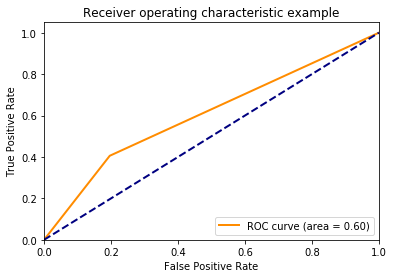

In [31]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

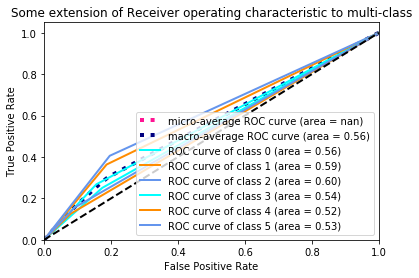

In [32]:
import numpy as np
from scipy import interp
from itertools import cycle

n_classes = 6

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Conclusion

The approach bases on BOW is bad for this task, so I will try iteratevly generate new features and add it to the model.